In [1]:
%load_ext autoreload
%autoreload 2

## One featurizer to rule them all?
Contrary to many other machine learning domains, _molecular_ featurization (i.e. the process of transforming a molecule into a vector) lacks a good default. It remains unclear how we can effectively capture the richness of molecular data in a unified representation and what works best heavily depends on the nature and constraints of the task you are trying to model. It is therefore good practice to try different featurization schemes: From structural fingerprints, to physico-chemical descriptors and pre-trained embeddings.

## Don't take our word for it
To demonstrate the impact a featurizer can have, we setup two simple benchmarks.
1. To demonstrate the impact on modeling, we will use two datasets from [MoleculeNet](https://moleculenet.org/datasets-1) [1].
2. To demonstrate the impact on search, we will use the [RDKit Benchmarking Platform](https://github.com/rdkit/benchmarking_platform) [2, 3].

We will compare the performance of three different featurizers:
- **ECFP6** [4]: Binary, circular fingerprints where each bit indicates the presence of particular substructures of a radius up to 3 bonds away from an atom.
- **Mordred** [5]: Continuous descriptors with more than 1800 2D and 3D descriptors.
- **ChemBERTa** [6]: Learned representations from a pre-trained SMILES transformer model.

### Modeling
We will compare the performance on two datasets using scikit-learn [AutoML](https://github.com/automl/auto-sklearn) [7, 8] models.

In [2]:
import os
import tqdm
import fsspec
import pickle
import warnings
import numpy as np
import pandas as pd
import datamol as dm
import matplotlib.pyplot as plt
import autosklearn.classification
import autosklearn.regression
from collections import defaultdict
from rdkit.Chem import SaltRemover

from sklearn.metrics import mean_absolute_error, roc_auc_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.neighbors import KNeighborsClassifier

from molfeat.trans.fp import FPVecTransformer
from molfeat.trans.pretrained.hf_transformers import PretrainedHFTransformer

In [3]:
# Making the output less verbose
warnings.simplefilter("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
dm.disable_rdkit_log()

In [4]:
def load_dataset(uri: str, readout_col: str):
    """Loads the MoleculeNet dataset"""
    df = pd.read_csv(uri)
    smiles = df["smiles"].values
    y = df[readout_col].values
    return smiles, y


def preprocess_smiles(smi):
    """Preprocesses the SMILES string"""
    mol = dm.to_mol(smi, ordered=True, sanitize=False)    
    try: 
        mol = dm.sanitize_mol(mol)
    except:
        mol = None
            
    if mol is None: 
        return
        
    mol = dm.standardize_mol(mol, disconnect_metals=True)
    remover = SaltRemover.SaltRemover()
    mol = remover.StripMol(mol, dontRemoveEverything=True)

    return dm.to_smiles(mol)


def scaffold_split(smiles):
    """In line with common practice, we will use the scaffold split to evaluate our models"""
    scaffolds = [dm.to_smiles(dm.to_scaffold_murcko(dm.to_mol(smi))) for smi in smiles]
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    return next(splitter.split(smiles, groups=scaffolds))


In [5]:
# Setup the featurizers
trans_ecfp = FPVecTransformer(kind="ecfp:6", n_jobs=-1)
trans_mordred = FPVecTransformer(kind="mordred", replace_nan=True, n_jobs=-1)
trans_chemberta = PretrainedHFTransformer(kind='ChemBERTa-77M-MLM', notation='smiles')

#### Lipophilicity
Lipophilicity is a regression task with 4200 molecules

In [6]:
# Prepare the Lipophilicity dataset
smiles, y_true = load_dataset("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/Lipophilicity.csv", "exp")
smiles = np.array([preprocess_smiles(smi) for smi in smiles])
smiles = np.array([smi for smi in smiles if dm.to_mol(smi) is not None])

feats_ecfp, ind_ecfp = trans_ecfp(smiles, ignore_errors=True)
feats_mordred, ind_mordred = trans_mordred(smiles, ignore_errors=True)
feats_chemberta, ind_chemberta = trans_chemberta(smiles, ignore_errors=True)

X = {
    "ECFP": feats_ecfp[ind_ecfp],
    "Mordred": feats_mordred[ind_mordred],
    "ChemBERTa": feats_chemberta[ind_chemberta],
}

In [7]:
# Train a model
train_ind, test_ind = scaffold_split(smiles)

lipo_scores = {}
for name, feats in X.items():
    
    # Train
    automl = autosklearn.regression.AutoSklearnRegressor(
        memory_limit=24576, 
        # For practicality’s sake, limit this to 10 minutes! 
        # (x3 = 30 min in total)
        time_left_for_this_task=360,  
        n_jobs=1,
        seed=1,
    )
    automl.fit(feats[train_ind], y_true[train_ind])
    
    # Predict and evaluate
    y_hat = automl.predict(feats[test_ind])
    
    # Evaluate
    mae = mean_absolute_error(y_true[test_ind], y_hat)
    lipo_scores[name] = mae

lipo_scores

[WARNING] [2023-03-24 18:21:50,652:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-03-24 18:22:04,898:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-03-24 18:22:06,370:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-03-24 18:24:44,990:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-03-24 18:24:48,684:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-03-24 18:24:58,518:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-03-24 18:27:38,490:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-03-24 18:27:43,678:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-03-24 18:28:02,760:Client-EnsembleBuilder] No runs were available to build an ensemble from


{'ECFP': 0.7635259340171177,
 'Mordred': 0.6244188277943119,
 'ChemBERTa': 0.7432117051810577}

#### ClinTox

In [11]:
# Prepare the ClinTox dataset
smiles, y_true = load_dataset("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/clintox.csv.gz", "CT_TOX")
smiles = np.array([preprocess_smiles(smi) for smi in smiles])
smiles = np.array([smi for smi in smiles if smi is not None])

feats_ecfp, ind_ecfp = trans_ecfp(smiles, ignore_errors=True)
feats_mordred, ind_mordred = trans_mordred(smiles, ignore_errors=True)
feats_chemberta, ind_chemberta = trans_chemberta(smiles, ignore_errors=True)

X = {
    "ECFP": feats_ecfp[ind_ecfp],
    "Mordred": feats_mordred[ind_mordred],
    "ChemBERTa": feats_chemberta[ind_chemberta],
}

[18:31:23] Unusual charge on atom 0 number of radical electrons set to zero
[18:31:24] Unusual charge on atom 0 number of radical electrons set to zero
[18:31:24] Unusual charge on atom 0 number of radical electrons set to zero
[18:31:24] Unusual charge on atom 0 number of radical electrons set to zero
[18:31:24] Unusual charge on atom 0 number of radical electrons set to zero


In [12]:
# Train a model
train_ind, test_ind = scaffold_split(smiles)

clintox_scores = {}
for name, feats in X.items():
    
    # Train
    automl = autosklearn.classification.AutoSklearnClassifier(
        memory_limit=24576, 
        # For practicality’s sake, limit this to 10 minutes! 
        # (x3 = 30 min in total)
        time_left_for_this_task=360,
        n_jobs=1,
        seed=1,
    )
    automl.fit(feats[train_ind], y_true[train_ind])
    
    # Predict and evaluate
    y_hat = automl.predict_proba(feats[test_ind])
    y_hat = y_hat[:, 1]
    
    # Evaluate
    auroc = roc_auc_score(y_true[test_ind], y_hat)
    clintox_scores[name] = auroc

clintox_scores

[WARNING] [2023-03-24 18:32:48,712:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-03-24 18:32:51,055:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-03-24 18:32:55,887:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-03-24 18:32:58,277:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-03-24 18:33:00,090:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-03-24 18:33:19,158:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WAR

Process ForkProcess-201:
Traceback (most recent call last):
  File "/home/cas/local/conda/envs/molfeat-benchmark/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/cas/local/conda/envs/molfeat-benchmark/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/cas/local/conda/envs/molfeat-benchmark/lib/python3.9/site-packages/autosklearn/util/logging_.py", line 317, in start_log_server
    receiver.serve_until_stopped()
  File "/home/cas/local/conda/envs/molfeat-benchmark/lib/python3.9/site-packages/autosklearn/util/logging_.py", line 347, in serve_until_stopped
    rd, wr, ex = select.select([self.socket.fileno()], [], [], self.timeout)
KeyboardInterrupt


[WARNING] [2023-03-24 18:34:06,857:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-03-24 18:34:10,593:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-03-24 18:34:13,335:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-03-24 18:34:15,804:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-03-24 18:34:18,674:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1



KeyboardInterrupt



#### Conclusion

| Dataset       | Metric | Representation | Score | Rank |
|---------------|--------|----------------|-------|------|
| Lipophilicity | MAE    | ECFP           | 0.689  | 1    |
|               |        | Mordred        | 0.529  | 0    |
|               |        | ChemBERTa      | 0.755  | 2    |
| ClinTox       | AUROC  | ECFP           | 0.528  | 2    |
|               |        | Mordred        | 0.575  | 1    |
|               |        | ChemBERTa      | 0.616  | 0    |

We can see that for Lipophilicity, the Mordred featurizer proves most powerful, outperforming the next best featurizer by over 20%. For ClinTox, however, the tables have turned and it is instead ChemBERTa that outperforms the other featurizers by about 7%. This shows the importance of trying different featurizers. Luckily, with Molfeat, this has just become a lot easier to do!

### Search
We will evaluate the performance on the search task using 

In [13]:
# Specify some meta-data

BASE_CMPD_URI = "https://github.com/rdkit/benchmarking_platform/raw/master/compounds/DUD/cmp_list_DUD"
CMPD_EXT = ".dat.gz"

BASE_SPLIT_URI = "https://github.com/rdkit/benchmarking_platform/raw/master/query_lists/data_sets_I/DUD/training_DUD"
SPLIT_EXT = ".pkl"

# Out of practicality, we only use the first 10 targets
TARGETS = [
    "ace",
    "ache",
    "ar",
    "cdk2",
    "cox2",
    "dhfr",
    "egfr",
    "er_agonist",
    "fgfr1",
    "fxa",
]

In [14]:
def get_compounds_for_target(target: str):
    """Loads the structural data"""
    df = pd.DataFrame()
    for subset in ["actives", "decoys"]:
        df_ = pd.read_csv(f"{BASE_CMPD_URI}_{target}_{subset}{CMPD_EXT}", sep="\t")
        df_["subset"] = subset
        df_["target"] = 1 if subset == "actives" else 0
        df = pd.concat([df, df_])
    return df


def get_train_decoy_split_for_target(target: str, no_of_actives: int = 20):
    """Loads the proposed split of the benchmark"""
    with fsspec.open(f"{BASE_SPLIT_URI}_{target}_{no_of_actives}{SPLIT_EXT}", "rb") as fd:
        data = pickle.load(fd)
    return data[:no_of_actives], data[no_of_actives:]

In [15]:
results = defaultdict(dict)

for target in tqdm.tqdm(TARGETS[:10], leave=False):

    # Load the structures (i.e. SMILES)
    df = get_compounds_for_target(target)
    n_actives = len(df[df["subset"] == "actives"])

    smiles = df["SMILES"].values
    smiles = np.array([smi for smi in smiles if dm.to_mol(smi) is not None])

    # Featurize
    feats_ecfp, ind_ecfp = trans_ecfp(smiles, ignore_errors=True)
    feats_mordred, ind_mordred = trans_mordred(smiles, ignore_errors=True)
    feats_chemberta, ind_chemberta = trans_chemberta(smiles, ignore_errors=True)

    X = {
        "ECFP": feats_ecfp[ind_ecfp],
        "Mordred": feats_mordred[ind_mordred],
        "ChemBERTa": feats_chemberta[ind_chemberta],
    }

    # Get the train-test split
    train_active_ind, train_decoy_ind = get_train_decoy_split_for_target(target, no_of_actives=20)
    train_decoy_ind = [i + n_actives for i in train_decoy_ind]

    for feat_name, feats in X.items():

        # Train the model
        knn = KNeighborsClassifier()
        train_ind = np.concatenate([train_active_ind, train_decoy_ind])
        test_ind = np.array([i for i in range(len(df)) if i not in train_ind])
        knn.fit(feats[train_ind], df.iloc[train_ind]["target"].values)

        # Get targets and predictions
        y_true = df.iloc[test_ind]["target"].values
        y_pred = knn.predict_proba(feats[test_ind])[:, 1]

        # Compute the recovery score
        auc = roc_auc_score(y_true, y_pred)
        results[feat_name][target] = auc

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 9/10 [15:18<01:48, 108.06s/it][18:49:58] Explicit valence for atom # 1 C greater than permitted
[18:49:58] Explicit valence for atom # 19 C greater than permitted
[18:49:58] Explicit valence for atom # 20 C greater than permitted
[18:49:58] Explicit valence for atom # 1 C greater than permitted
[18:49:58] Explicit valence for atom # 20 C greater than permitted
[18:49:58] Explicit valence for atom # 20 C greater than permitted[18:49:58] Explicit valence for atom # 1 C greater than permitted

[18:49:58] Explicit valence for atom # 20 C greater than permitted
[18:49:58] Explicit valence for atom # 19 C greater than permitted
[18:49:58] Explicit valence for atom # 1 C greater than permitted
[18:49:58] Explicit valence for atom # 21 C greater than permitted
[18:49:58] Explicit valence for atom 

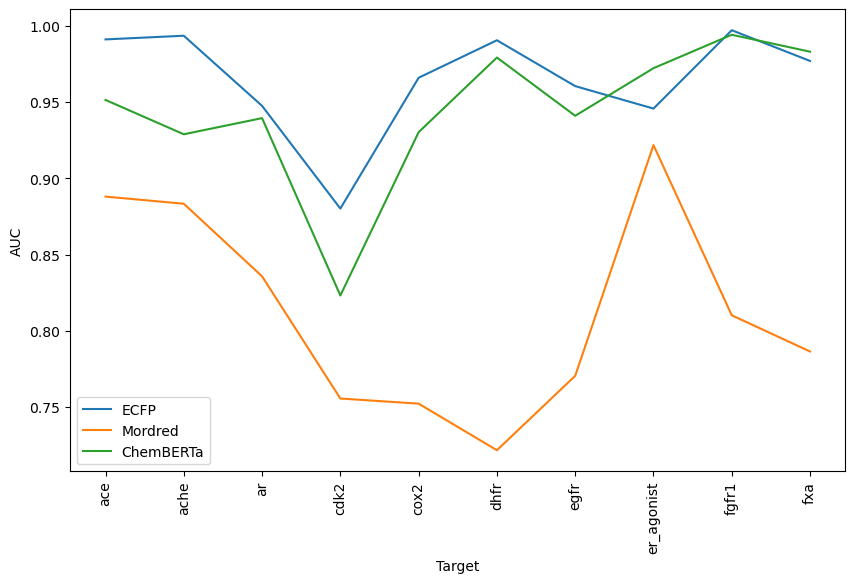

In [16]:
# Replicate the figure from https://doi.org/10.1021/ci400466r

xs = list(range(len(TARGETS)))

ecfp_scores = [results["ECFP"][target] for target in TARGETS]
mordred_scores = [results["Mordred"][target] for target in TARGETS]
chemberta_scores = [results["ChemBERTa"][target] for target in TARGETS]

fig, ax = plt.subplots(figsize=(10, 6))
for scores, label in zip([ecfp_scores, mordred_scores, chemberta_scores], ["ECFP", "Mordred", "ChemBERTa"]):
    ax.plot(xs, scores, label=label)

ax.set_xlabel("Target")
ax.set_ylabel("AUC")
ax.set_xticks(xs)
ax.set_xticklabels(TARGETS, rotation=90)
ax.legend()

#### Conclusion
For search, we observe yet again that the performance heavily depends on the featurizer. 

## Citations
1. Wu, Z., Ramsundar, B., Feinberg, E. N., Gomes, J., Geniesse, C., Pappu, A. S., ... & Pande, V. (2018). MoleculeNet: a benchmark for molecular machine learning. Chemical science, 9(2), 513-530.
2. Riniker, S., Fechner, N., & Landrum, G. A. (2013). Heterogeneous classifier fusion for ligand-based virtual screening: or, how decision making by committee can be a good thing. Journal of chemical information and modeling, 53(11), 2829-2836.
3. Riniker, S., & Landrum, G. A. (2013). Open-source platform to benchmark fingerprints for ligand-based virtual screening. Journal of cheminformatics, 5(1), 26.
4. Rogers, D., & Hahn, M. (2010). Extended-connectivity fingerprints. Journal of chemical information and modeling, 50(5), 742-754.
5. Moriwaki, H., Tian, Y. S., Kawashita, N., & Takagi, T. (2018). Mordred: a molecular descriptor calculator. Journal of cheminformatics, 10(1), 1-14.
6. Chithrananda, S., Grand, G., & Ramsundar, B. (2020). Chemberta: Large-scale self-supervised pretraining for molecular property prediction. arXiv preprint arXiv:2010.09885.
7. Efficient and Robust Automated Machine Learning Matthias Feurer, Aaron Klein, Katharina Eggensperger, Jost Springenberg, Manuel Blum and Frank Hutter Advances in Neural Information Processing Systems 28 (2015)
8. Auto-Sklearn 2.0: The Next Generation Matthias Feurer, Katharina Eggensperger, Stefan Falkner, Marius Lindauer and Frank Hutter* arXiv:2007.04074 [cs.LG], 2020
